In [1]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 36 µs, sys: 9 µs, total: 45 µs
Wall time: 49.6 µs


In [2]:
%%time

import tensorflow as tf
import tensorflow_hub as hub

# Load the YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

CPU times: user 12.7 s, sys: 1.69 s, total: 14.4 s
Wall time: 21.8 s


In [3]:
%%time

import os

# Directory containing the audio files
audio_directory = '/kaggle/input/birdclef-2024/train_audio'

def list_audio_files(audio_directory):
    """
    List all subdirectories and their files in the audio directory.
    
    Parameters:
    -----------
    audio_directory : str
        Path to the main audio directory (train_audio)
        
    Returns:
    --------
    None : Prints the subdirectory and lists the files within it.
    """
    # Walk through the directory
    for root, dirs, files in os.walk(audio_directory):
        # If there are no subdirectories, skip the loop
        if len(files) == 0:
            continue
        
        # Extract subdirectory name (e.g., 'asbfly', 'ashdro1', etc.)
        subdirectory = os.path.basename(root)
        print(f"\n{subdirectory}:\n" + "-" * len(subdirectory))
        
        # List files in the current subdirectory
        for file in files:
            if file.lower().endswith('.ogg'):  # Only list .ogg files
                print(f"  {file}")

# Run the function
list_audio_files(audio_directory)


redspu1:
-------
  XC312771.ogg
  XC37584.ogg
  XC283501.ogg
  XC469479.ogg
  XC471046.ogg
  XC760790.ogg
  XC623939.ogg
  XC356035.ogg
  XC634745.ogg
  XC775566.ogg
  XC325427.ogg
  XC395166.ogg
  XC296423.ogg
  XC540542.ogg
  XC668357.ogg
  XC284532.ogg

zitcis1:
-------
  XC583640.ogg
  XC301756.ogg
  XC568234.ogg
  XC639178.ogg
  XC562093.ogg
  XC784863.ogg
  XC292988.ogg
  XC732693.ogg
  XC330942.ogg
  XC704584.ogg
  XC570083.ogg
  XC633801.ogg
  XC368394.ogg
  XC567945.ogg
  XC689204.ogg
  XC727228.ogg
  XC268232.ogg
  XC713317.ogg
  XC746992.ogg
  XC282659.ogg
  XC764144.ogg
  XC738158.ogg
  XC717577.ogg
  XC821860.ogg
  XC630728.ogg
  XC179034.ogg
  XC578320.ogg
  XC773615.ogg
  XC356560.ogg
  XC557791.ogg
  XC526227.ogg
  XC761035.ogg
  XC376645.ogg
  XC459013.ogg
  XC559427.ogg
  XC793021.ogg
  XC263698.ogg
  XC527576.ogg
  XC776863.ogg
  XC379642.ogg
  XC337543.ogg
  XC431788.ogg
  XC305008.ogg
  XC534124.ogg
  XC310878.ogg
  XC542018.ogg
  XC398540.ogg
  XC443818.ogg
  XC7

Processing audio files...
Processed: XC312771.ogg - Class: Bird - Confidence: 0.858
Processed: XC37584.ogg - Class: Animal - Confidence: 0.143
Processed: XC283501.ogg - Class: Animal - Confidence: 0.467
Processed: XC469479.ogg - Class: Animal - Confidence: 0.662
Processed: XC471046.ogg - Class: Silence - Confidence: 0.436
Processed: XC760790.ogg - Class: Speech - Confidence: 0.232
Processed: XC623939.ogg - Class: Silence - Confidence: 0.338
Processed: XC356035.ogg - Class: Animal - Confidence: 0.777
Processed: XC634745.ogg - Class: Animal - Confidence: 0.594
Processed: XC775566.ogg - Class: Animal - Confidence: 0.600
Processed: XC325427.ogg - Class: Speech - Confidence: 0.134
Processed: XC395166.ogg - Class: Animal - Confidence: 0.588
Processed: XC296423.ogg - Class: Animal - Confidence: 0.455
Processed: XC540542.ogg - Class: Animal - Confidence: 0.249
Processed: XC668357.ogg - Class: Animal - Confidence: 0.697
Processed: XC284532.ogg - Class: Animal - Confidence: 0.437
Processed: XC58

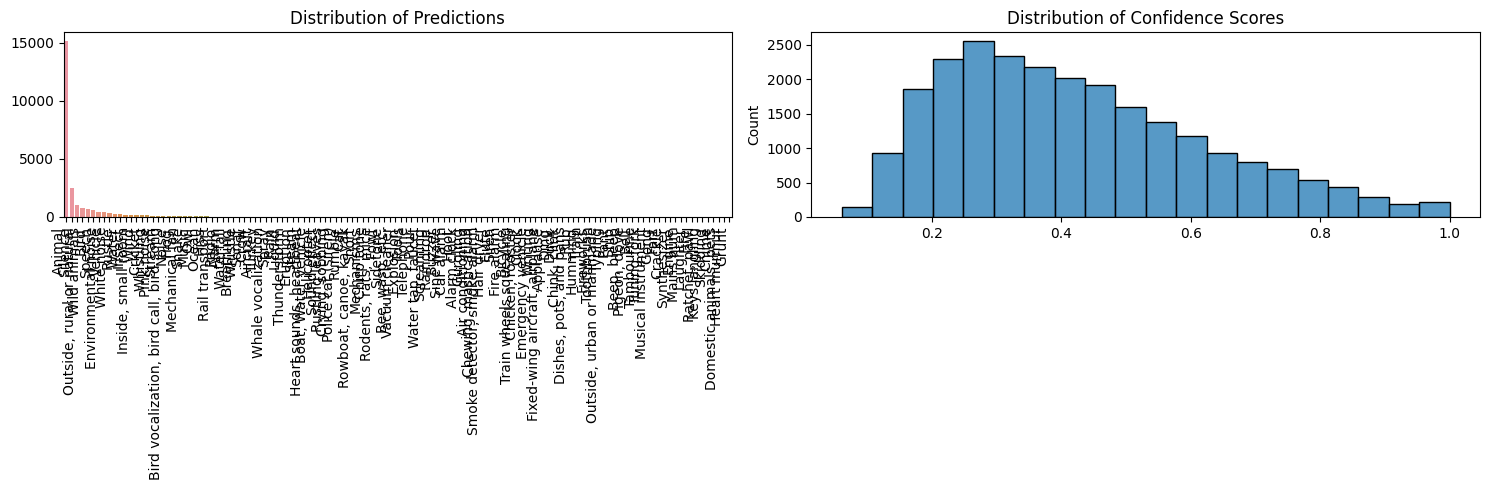

CPU times: user 54min 46s, sys: 1min, total: 55min 46s
Wall time: 1h 20s


In [5]:
%%time

import os
import librosa
import numpy as np
import soundfile as sf  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import io
import csv

# Function to extract class names from the model's class_map_path
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_map_csv = io.StringIO(class_map_csv_text)
    # Skip the header
    csv_reader = csv.reader(class_map_csv)
    next(csv_reader)
    class_names = [display_name for (class_index, mid, display_name) in csv_reader]
    return class_names

# Load class names from the model's class_map_path
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

def preprocess_audio(audio_file_path, target_sr=22050):
    """
    Preprocess audio file for YAMNet input.

    Parameters:
    -----------
    audio_file_path : str
        Path to audio file
    target_sr : int
        Target sampling rate (YAMNet expects 16kHz)
        
    Returns:
    --------
    numpy array : Preprocessed audio waveform
    """
    try:
        # Load and resample audio 
        waveform, sr = librosa.load(audio_file_path, sr=target_sr)
        
        # Ensure minimum duration (1 second)
        if len(waveform) < target_sr:
            waveform = np.pad(waveform, (0, target_sr - len(waveform)))
        
        return waveform
        
    except Exception as e:
        print(f"Error processing {audio_file_path}: {str(e)}")
        return None

def classify_audio_file(audio_file_path):
    """
    Classify audio file using YAMNet.

    Parameters:
    -----------
    audio_file_path : str
        Path to audio file
        
    Returns:
    --------
    tuple : (predicted_class, confidence_score)
    """
    try:
        # Preprocess audio
        waveform = preprocess_audio(audio_file_path, target_sr=22050)  # YAMNet expects 16kHz
        if waveform is None:
            return None, None
        
        # Run the model
        scores, embeddings, spectrogram = yamnet_model(waveform)
        
        # Get the predicted class and confidence
        class_scores = scores.numpy().mean(axis=0)
        predicted_class_idx = np.argmax(class_scores)
        confidence_score = class_scores[predicted_class_idx]
        
        # Get class name from the loaded class names
        predicted_class = class_names[predicted_class_idx]
        
        return predicted_class, confidence_score
        
    except Exception as e:
        print(f"Error classifying {audio_file_path}: {str(e)}")
        return None, None

def process_audio_directory(audio_directory, limit=None):
    """
    Process all audio files in the given directory and classify them.

    Parameters:
    -----------
    audio_directory : str
        Path to directory containing audio files
    limit : int, optional
        Maximum number of files to process
        
    Returns:
    --------
    list : List of (filename, prediction, confidence) tuples
    """
    results = []
    
    # Define directory files
    for root, dirs, files in os.walk(audio_directory):
        for audio_file in files:
            if audio_file.lower().endswith('.ogg'):
                audio_file_path = os.path.join(root, audio_file)
                predicted_class, confidence = classify_audio_file(audio_file_path)
                
                if predicted_class is not None:
                    results.append((audio_file, predicted_class, confidence))
                    print(f"Processed: {audio_file} - Class: {predicted_class} - Confidence: {confidence:.3f}")
                
                if limit and len(results) >= limit:
                    return results
    
    return results

def plot_results(results):
    """
    Plot classification results.

    Parameters:
    -----------
    results : list
        List of (filename, prediction, confidence) tuples
    """
    if not results:
        print("No results to plot.")
        return
    
    # Extract predictions and confidences
    predictions = [r[1] for r in results]
    confidences = [r[2] for r in results]
    
    # Plot distribution of predictions
    plt.figure(figsize=(15, 5))
    
    # Prediction distribution
    plt.subplot(1, 2, 1)
    pred_counts = pd.Series(predictions).value_counts()
    sns.barplot(x=pred_counts.index, y=pred_counts.values)
    plt.xticks(rotation=90, ha='right')
    plt.title('Distribution of Predictions')
    
    # Confidence distribution
    plt.subplot(1, 2, 2)
    sns.histplot(confidences, bins=20)
    plt.title('Distribution of Confidence Scores')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Directory containing the audio files
    audio_directory = '/kaggle/input/birdclef-2024/train_audio'
    
    # Process audio files
    print("Processing audio files...")
    results = process_audio_directory(audio_directory)
    
    # Create DataFrame 
    if results:
        df_results = pd.DataFrame(results, columns=['filename', 'prediction', 'confidence'])
    
        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        print(f"Total files processed: {len(df_results)}")
        print("\nPrediction counts:")
        print(df_results['prediction'].value_counts().head())
        print("\nConfidence score statistics:")
        print(df_results['confidence'].describe())
        
        # Plot results
        plot_results(results)
    else:
        print("No audio files processed successfully.")

* The score 1.0 is the model is completely sure that the sound is a class category

* The score 0.5 is the model not very sure and could just as easily say it's something else, like "animal" or "noise."

# Save .ogg Files with High Confidence Scores

In [6]:
%%time

# Function to extract class names from the model's class_map_path
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    import csv
    import io
    class_map_csv = io.StringIO(class_map_csv_text)
    class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
    class_names = class_names[1:]  # Skip CSV header
    return class_names

# Load class names from the model's class_map_path
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

def preprocess_audio(audio_file_path, target_sr=22050):
    """
    Preprocess audio file for YAMNet input.
    """
    try:
        # Load and resample audio 
        waveform, sr = librosa.load(audio_file_path, sr=target_sr)
        
        # Ensure minimum duration (1 second)
        if len(waveform) < target_sr:
            waveform = np.pad(waveform, (0, target_sr - len(waveform)))
        
        return waveform
        
    except Exception as e:
        print(f"Error processing {audio_file_path}: {str(e)}")
        return None

def classify_audio_file(audio_file_path):
    """
    Classify audio file using YAMNet.
    Returns tuple: (predicted_class, confidence_score).
    """
    try:
        # Preprocess audio
        waveform = preprocess_audio(audio_file_path, target_sr=22050)  # YAMNet expects 16kHz
        if waveform is None:
            return None, None
        
        # Run the model
        scores, embeddings, spectrogram = yamnet_model(waveform)
        
        # Get the predicted class and confidence
        class_scores = scores.numpy().mean(axis=0)
        predicted_class_idx = np.argmax(class_scores)
        confidence_score = class_scores[predicted_class_idx]
        
        # Get class name from the loaded class names
        predicted_class = class_names[predicted_class_idx]
        
        return predicted_class, confidence_score
        
    except Exception as e:
        print(f"Error classifying {audio_file_path}: {str(e)}")
        return None, None

def process_audio_directory_and_save(audio_directory, confidence_threshold=0.8, output_csv='high_confidence_predictions.csv'):
    """
    Process all audio files, classify them, and save files with high confidence scores.
    
    Parameters:
    -----------
    audio_directory : str
        Path to directory containing audio files
    confidence_threshold : float
        Minimum confidence score to save a file
    output_csv : str
        Name of the output CSV file to save the high confidence predictions
        
    Returns:
    --------
    None
    """
    results = []
    
    # Define the directory and process each file
    for root, dirs, files in os.walk(audio_directory):
        for audio_file in files:
            if audio_file.lower().endswith('.ogg'):
                audio_file_path = os.path.join(root, audio_file)
                predicted_class, confidence = classify_audio_file(audio_file_path)
                
                # Only keep files with confidence >= threshold
                if predicted_class is not None and confidence >= confidence_threshold:
                    results.append({
                        'file_name': audio_file, 
                        'predicted_class': predicted_class, 
                        'confidence_score': confidence
                    })
                    print(f"Processed: {audio_file} - Class: {predicted_class} - Confidence: {confidence:.3f}")
    
    # Save the results to a CSV file
    if results:
        df_results = pd.DataFrame(results)
        df_results.to_csv(output_csv, index=False)
        print(f"Saved high confidence predictions to {output_csv}")
    else:
        print("No files met the confidence threshold.")

# Main execution
if __name__ == "__main__":
    # Directory containing the audio files
    audio_directory = '/kaggle/input/birdclef-2024/train_audio'
    
    # Process audio files and save those with high confidence predictions (e.g., > 0.8)
    process_audio_directory_and_save(audio_directory, confidence_threshold=0.8)

Processed: XC312771.ogg - Class: Bird - Confidence: 0.858
Processed: XC567945.ogg - Class: Animal - Confidence: 0.863
Processed: XC717577.ogg - Class: Wild animals - Confidence: 0.835
Processed: XC459013.ogg - Class: Bird - Confidence: 0.860
Processed: XC570141.ogg - Class: Bird vocalization, bird call, bird song - Confidence: 0.839
Processed: XC378696.ogg - Class: Animal - Confidence: 0.803
Processed: XC469524.ogg - Class: Animal - Confidence: 0.813
Processed: XC128122.ogg - Class: Animal - Confidence: 0.897
Processed: XC600357.ogg - Class: Silence - Confidence: 0.951
Processed: XC626814.ogg - Class: Wild animals - Confidence: 0.819
Processed: XC724803.ogg - Class: Animal - Confidence: 0.825
Processed: XC607472.ogg - Class: Animal - Confidence: 0.843
Processed: XC146955.ogg - Class: Bird vocalization, bird call, bird song - Confidence: 0.859
Processed: XC714889.ogg - Class: Animal - Confidence: 0.812
Processed: XC251946.ogg - Class: Animal - Confidence: 0.847
Processed: XC585417.ogg -